# Practical 10: Neural Machine Translation
#### Ayoub Bagheri
<img src="img/uu_logo.png" alt="logo" align="right" title="UU" width="50" height="20" />

#### Applied Text Mining - Utrecht Summer School

Welcome to the last practical of the course “Applied Text Mining”. 

In this practical, we will create models for neural machine translation. Today we are curious to see how a simple deep learning based model translates a sentence into its counterpart. See these examples:

<img src="translation_example.png" />

<img src="translation_example2.png" />

The objective from this practical is to convert a Dutch sentence to its English counterpart using a Neural Machine Translation (NMT) system. We will implement this task by building a simple Sequence-to-Sequence model with the help of Keras library.

Today we will use the following libraries. Take care to have them installed!

In [1]:
import string
import re
import statistics
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Let's get started!

1\. **In this practical we will use a data set of tab-delimited Bilingual Sentence Pairs from http://www.manythings.org/anki/. Use the following two functions (read_text and to_lines) and read the nld.txt data set (also provided in the course webpage next to the practial link). This data set contains phrases in Dutch with their translation in English. Convert the text sequences to an array and check the first items in your array.**

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("nld-eng/nld.txt")
nld_eng = to_lines(data)
nld_eng = array(nld_eng)

In [5]:
nld_eng.shape

(54972, 3)

In [6]:
nld_eng

array([['Go.', 'Lopen!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['Go.', 'Vooruit.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['Hi.', 'Hoi.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['Always use distilled water in steam irons because using ordinary water will cause a mineral build-up over time that will clog the steam holes.',
        'Gebruik altijd gedistilleerd water in stoomstrijkijzers, want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ["If you translate from your second language into your own native language, rather than the other way around, you're less likely to make mistakes.",
        'Als je vanuit je tweede taal naar je eigen moedertaal v

Using a code like nld_eng = nld_eng[:1000,:], you can use a subset of data, for example the first 1000 sentence pairs, to reduce the training time of the model. Be aware that you will lose the performance.

# Pre-processing

2\. **Use the maketrans() function to remove punctuations from the nld_enp object. The maketrans() function is a function from the library str that is used to construct a transition table, i.e that it specifies a list of characters that need to be replaced in a string or the characters that need to be deleted from the string. To use this transition table, you can use the translate() function and apply that on a string. It is also possible to use these functions to remove the punctuations. Similar to the example below, apply the maketrans() function to remove punctuations from the nld_eng array.**

In [7]:
### Here you see an example on how to use the maketrans() function ###
# specify the list of characters that need to be replaced
str1 = "mtex"

# specify the list of characters with which the characters need to be replaced
str2 = "dwoo"

# specify the list of characters that needs to be deleted
str3 = "u"

# target string 
temp_str = "text mining"

# using maketrans() to construct a translate table
table = temp_str.maketrans(str1, str2, str3)
  
# Printing original string 
print ("The string before translating is : ", end ="")
print (temp_str)
  
# using translate() to make translations.
print ("The string after translating is : ", end ="")
print (temp_str.translate(table))

The string before translating is : text mining
The string after translating is : woow dining


Note that it is possible to replace one character with two or more. You need to supply a dict as argument to maketrans().

In [8]:
nld_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,0]]
nld_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,1]]

In [9]:
nld_eng

array([['Go', 'Lopen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['Go', 'Vooruit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['Hi', 'Hoi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['Always use distilled water in steam irons because using ordinary water will cause a mineral buildup over time that will clog the steam holes',
        'Gebruik altijd gedistilleerd water in stoomstrijkijzers want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ['If you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'Als je vanuit je tweede taal naar je eigen moedertaal vertaalt in pla

3\. **Convert all words into their lowercase.**

In [10]:
# convert to lowercase
for i in range(len(nld_eng)):
    nld_eng[i,0] = nld_eng[i,0].lower()    
    nld_eng[i,1] = nld_eng[i,1].lower()

In [11]:
nld_eng

array([['go', 'lopen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['go', 'vooruit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['hi', 'hoi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['always use distilled water in steam irons because using ordinary water will cause a mineral buildup over time that will clog the steam holes',
        'gebruik altijd gedistilleerd water in stoomstrijkijzers want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ['if you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'als je vanuit je tweede taal naar je eigen moedertaal vertaalt in pla

# Text to Sequence

4\. **What is the maximum length of a sentence in each of the Dutch and English sets? What about the average length?**

In [12]:
# empty lists
eng_l = []
nld_l = []
# populate the lists with sentence lengths
for i in nld_eng[:,0]:
    eng_l.append(len(i.split()))

for i in nld_eng[:,1]:
    nld_l.append(len(i.split()))

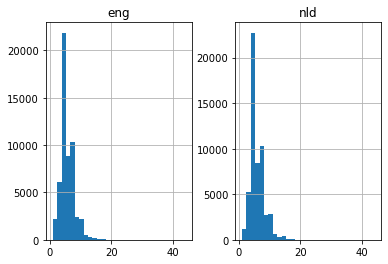

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'nld':nld_l})
length_df.hist(bins = 30)
plt.show()

In [14]:
max(eng_l)

44

In [15]:
max(nld_l)

44

In [16]:
type(nld_l)

list

In [17]:
statistics.mean(nld_l)

5.853307138179437

In [18]:
statistics.mean(eng_l)

5.619569962890199

Coincidentally the maximum length of the Dutch sentences and that of the English phrases is equal to 44.

5\. **Use the train_test_split function from sklearn to split the data set into training (80%) and test (20%) sets.**

In [19]:
train, test = train_test_split(nld_eng, test_size=0.2, random_state=321)

6\. **Time to tokenize the sentences. Use the Tokenizer function from Keras and fit the sentences. Find out about the vocabulary size for the Dutch and English sets.**

In [20]:
# prepare english tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(nld_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9073


In [21]:
# prepare Dutch tokenizer
nld_tokenizer = Tokenizer()
nld_tokenizer.fit_on_texts(nld_eng[:, 1])
nld_vocab_size = len(nld_tokenizer.word_index) + 1
print('Dutch Vocabulary Size: %d' % nld_vocab_size)
# print('Dutch Vocabulary Size:', nld_vocab_size)

Dutch Vocabulary Size: 12794


7\. **Write a function to convert tokens into sequences using an argument for maximum sentence length. Other input arguments to this function are tokenizer and sentences, and its output will be sequences of tokens.**

In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, maximum_length, sentences):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(sentences)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=maximum_length, padding='post')
    return seq

8\. **Convert your tokenized training data into sequences. Use a maximum length of 20 and name the dataframes train_X and train_Y.**

In [23]:
eng_length = 40
nld_length = 40
# prepare training data
train_X = encode_sequences(nld_tokenizer, nld_length, train[:, 1])
train_Y = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

9\. **In the same way, convert your tokenized test data into sequences and name the dataframs test_X and test_Y.**

In [24]:
# prepare test data
test_X = encode_sequences(nld_tokenizer, nld_length, test[:, 1])
test_Y = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# Neural Network Model

10\. **Defince a Seq2Seq model architecture using an Embedding layer as the input layer, an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder. Make this a function and name it build_model(). Define different input arguments for your function including the embedding_size and the number of LSTM units.**

In [25]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, embedding_size, LSTMunits):
    model = Sequential()
    model.add(Embedding(in_vocab, embedding_size, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(LSTMunits))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(LSTMunits, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

11\. **Create a model by calling the function with embedding_size of 300 and 512 units for the LSTM layers.**

In [26]:
model = build_model(nld_vocab_size, 
                    eng_vocab_size, 
                    nld_length, 
                    eng_length, 
                    300, 
                    512)

12\. **Compile the model with the RMSprop optimizer and sparse_categorical_crossentropy for loss.**

In [27]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           3838200   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1665024   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 512)           2099200   
_________________________________________________________________
dense (Dense)                (None, 40, 9073)          4654449   
Total params: 12,256,873
Trainable params: 12,256,873
Non-trainable params: 0
_________________________________________________________________


Note that we have used 'sparse_categorical_crossentropy' as the loss function as it allows us to use the target sequence as it is instead of one-hot encoded format. One-hot encoding the target sequences with such a huge vocabulary might consume your system's entire memory.

13\. **Fit the model with your desired number of epochs (e.g. 1 :)), validation_split of 0.2, and batch_size of 128. You can use smaller values for the number of LSTM units (100) and embedding size (50) if it takes a lot of time to run.**

In [28]:
# history = model.fit(train_X, train_Y.reshape(train_Y.shape[0], train_Y.shape[1], 1), 
#                    epochs=2, 
#                    batch_size=128, 
#                    validation_split = 0.2,
#                    verbose=1)

With ModelCheckpoint you can save your best model during the training. We used this option of Keras to run our neural translator for 15 epochs and save the model for your use.

In [29]:
filename = 'model.15Epochs'
checkpoint = ModelCheckpoint(filename, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

history = model.fit(train_X, train_Y.reshape(train_Y.shape[0], train_Y.shape[1], 1),
                    epochs=15,
                    batch_size=128, 
                    validation_split = 0.2,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/15
275/275 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.8638
Epoch 00001: val_loss improved from inf to 0.89008, saving model to model.15Epochs
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model.15Epochs\assets
275/275 [==============================] - 662s 2s/step - loss: 1.0358 - accuracy: 0.8638 - val_loss: 0.8901 - val_accuracy: 0.8688
Epoch 2/15
275/275 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.8756
Epoch 00002: val_loss improved from 0.89008 to 0.79787, saving model to model.15Epochs
INFO:tensorflow:Assets written to: model.15Epochs\assets
275/275 [==============================] - 691s 3s/step - loss: 0.8327 - accuracy: 0.8756 - val_loss: 0.7979 - val_accuracy: 0.8799
Epoch 3/15
275/275 [==============================] - ETA: 0s - loss: 0.7589 - accuracy: 0.8841
Epoch 00003: val_loss improved from 0.79787 to 0.75407, saving model to model.15Epo

14\. **Plot the accuracy and loss of your model for the training and validations sets.**

We will use the plot_history function from the previous practical:

In [30]:
plt.style.use('ggplot')
def plot_history(history, val=0):
    acc = history.history['accuracy']
    if val == 1:
        val_acc = history.history['val_accuracy'] # we can add a validation set in our fit function with nn
    loss = history.history['loss']
    if val == 1:
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    if val == 1:
        plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    if val == 1:
        plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.legend()

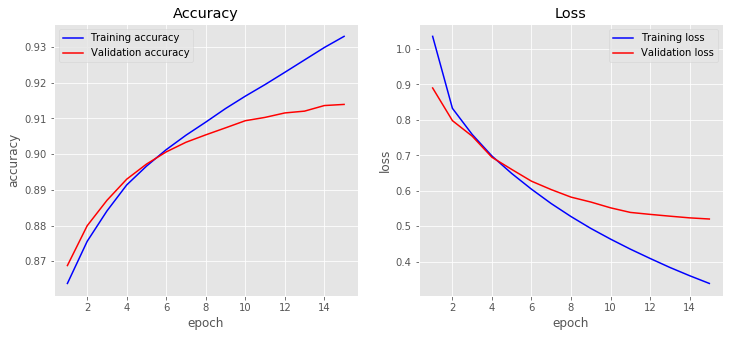

In [31]:
plot_history(history, val=1)

You can also use the following code without the plot_history function:

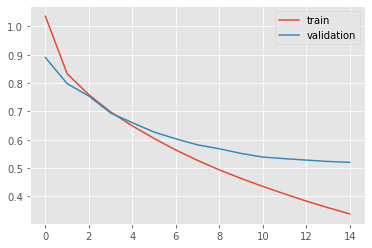

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

15\. **Predict translations for the test set.**

You can continue using your model or you can use the following code to load the trained model with 10 epochs. Remember that our chosen architecture for a deep learning encoder-decoder translation model is a very simple architecture.

In [33]:
# model = load_model('model.15Epochs')

In [34]:
preds = model.predict_classes(test_X.reshape((test_X.shape[0],test_X.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [35]:
preds

array([[   6, 1044,  330, ...,    0,    0,    0],
       [   2,  184,   23, ...,    0,    0,    0],
       [   2,  416,    7, ...,    0,    0,    0],
       ...,
       [   4,   49,  365, ...,    0,    0,    0],
       [ 120,  143,  486, ...,    0,    0,    0],
       [   3,   35,   19, ...,    0,    0,    0]], dtype=int64)

As you noticed preds are only indices of words, so we need to convert them to words to be able to read them.

16\. **Use the sequences_to_texts function to convert an index to a word on your predictions.**

In [36]:
preds_text = eng_tokenizer.sequences_to_texts(preds)

In [37]:
preds_text

['a earthquake wearing a a a',
 'the children for week',
 'the light is green',
 'are you enough enough',
 'are we in',
 'many flowers are made in are',
 'dont not not on the the',
 'i know i see it',
 'the ship is is',
 'its is something i can to do',
 'she just just been',
 'i in i i in very',
 'you can know him to his his',
 'will we go to the the bus',
 'lets play baseball',
 'i like to a at the tomorrow tomorrow',
 'christmas is larger than than',
 'according was was the the the of of the the the',
 'see the the',
 'i assume you you to if if you you to',
 'we been there three three three',
 'who are your hair',
 'how was in australia',
 'im am the',
 'who is',
 'my father gave me a cake',
 'my sister sister is brothers',
 'if will later if but will',
 'do you like like some some',
 'the boy was born in the the world',
 'when does the the',
 'write your name in capital',
 'london is a favorite subject the worth',
 'we have a new clock',
 'a man is the the road',
 'are you busy',
 '

17\. **Create a new dataframe with three columns where you show the input Dutch text of the test set, the actual output, and your predictions. Use the sample() function with your dataframe to randomly check some of the lines.**

In [44]:
pred_df = pd.DataFrame({'input' : test[:, 1], 'actual output' : test[:,0], 'predicted output' : preds_text})

In [39]:
#pd.set_option('display.max_colwidth', 50)

In [45]:
pred_df.head(15)

,input,actual output,predicted output
0,een aap beklimt een hoge boom,a monkey is climbing up a tall tree,a earthquake wearing a a a
1,de vredesonderhandelingen beginnen deze week,the peace talks begin this week,the children for week
2,het licht is groen,the light is green,the light is green
3,krijgt u genoeg zuurstof,are you getting enough oxygen,are you enough enough
4,zijn ze in leven,are they alive,are we in
5,veel mooie bloemen bloeien in de lente,many pretty flowers bloom in the spring,many flowers are made in are
6,onbevoegden zijn niet toegestaan op het terrein,no unauthorised persons will be permitted inside the perimeter,dont not not on the the
7,ik weet dat ik het erin heb gestopt,i know i packed it,i know i see it
8,het water stijgt,the water is rising,the ship is is
9,het is iets wat ze altijd wilden doen,its something they always wanted to do,its is something i can to do


In [41]:
pred_df

,actual,predicted
0,a monkey is climbing up a tall tree,a earthquake wearing a a a
1,the peace talks begin this week,the children for week
2,the light is green,the light is green
3,are you getting enough oxygen,are you enough enough
4,are they alive,are we in
...,...,...
10990,i like dogs,i love dogs
10991,i noticed you didnt finish your dinner,i didnt you you your your your
10992,tom didnt even know who mary was,tom didnt even know mary was was
10993,few people are able to understand his theories,some people decided people is are are are


In [46]:
pred_df.sample(15)

,input,actual output,predicted output
4236,wat heb je besloten,what have you decided,what did you
3325,hij keek neer op de vallei onder hem,he looked down at the valley below,he looked out out the the
2855,ik denk dat dat aan tom verteld moet worden,i think tom needs to be told that,i think tom should to to
3365,tom heeft een hekel aan klerken,tom hates clerks,tom hates hates
916,het werd in olie gebakken,that was cooked in oil,it was in in
9413,waarom zijn jullie getrouwd,why are you married,why are you married
8726,de politiemannen arresteerden de inbreker,the policemen arrested the burglar,the moon says the means
3322,ik zal terug zijn om 230,ill be back at 230,ill be back by
6718,ik kan me niet herinneren wat tom deed,i dont remember what tom did,i cant remember what did did
10403,zij stierven op het slachtveld,they died on the battlefield,she is on the south


18\. **Tatoeba.org (https://tatoeba.org/en/downloads) has a large database of example sentences translated into many languages by volunteers. To have a better data for your neural machine translator you can use this tool to generate and download customized sentence pairs. For example it has more than one million sentence pairs translated from Dutch to English. This time, try to tune the hyperparameters and add an attention layer after the dense layer.**